In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

## data energy consumption

In [3]:
data_energy = pd.read_csv("../data/energy_consump.csv")

In [4]:
data_energy.Date = data_energy.Date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [5]:
data = data_energy.EnergyConsump[data_energy.EnergyConsump.notna()]

In [6]:
len(data)

1959

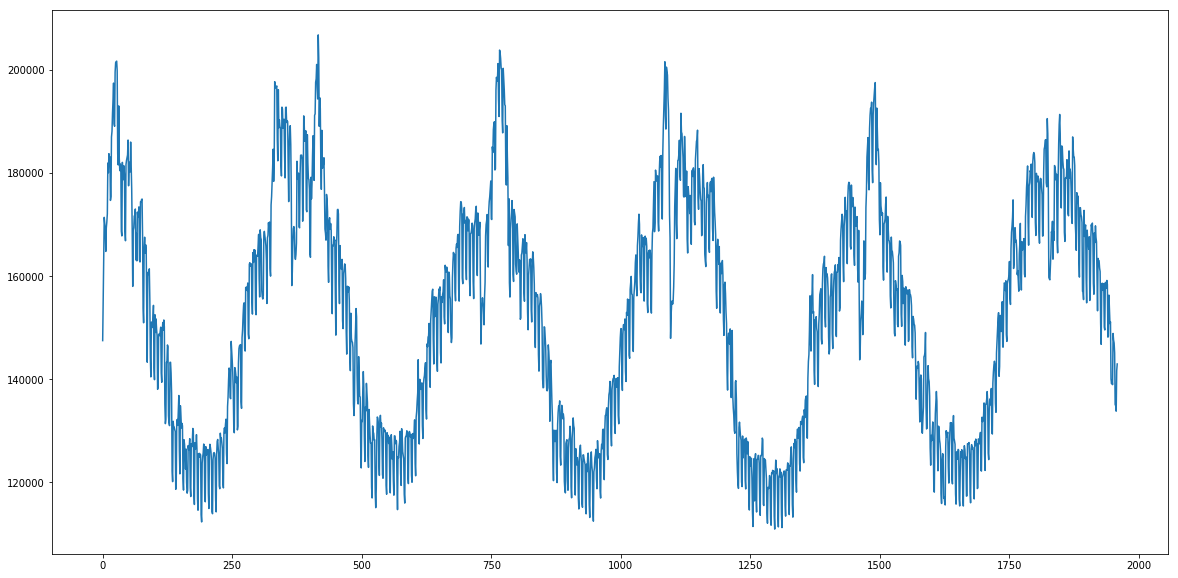

In [7]:
plt.plot(data);

## model

In [8]:
class ARI:
    def __init__(self, window, s=[10], d=1, n=1):
        self.d = d
        self.s = s
        self.n = n
        self.window  = window
        self.weights = np.array([])
        self.diff_matrix = []
        self.point = np.array([])
    
    
    def difference(self, data):
        old_diff_data = None
        diff_data = data
        self.diff_matrix.append(data)
        
        for k in range(len(self.s)):
            old_diff_data = diff_data
            diff_data = []
            assert self.s[k] < len(old_diff_data)
            for i in range(self.s[k], len(old_diff_data)):
                diff_data.append(old_diff_data[i] - old_diff_data[i-self.s[k]])
            self.diff_matrix.append(diff_data)
        for d in range(self.d):
            old_diff_data = diff_data
            diff_data = []
            for j in range(1, len(old_diff_data)):
                diff_data.append(old_diff_data[j] - old_diff_data[j-1])
            self.diff_matrix.append(diff_data)
            
        return diff_data
    
    
    def regresion(self, features, targets):
        weights = ((inv((features.T).dot(features))).dot(
            features.T)).dot(targets)
        return weights
    
    
    def train(self, raw_data):
        data = self.difference(raw_data)
        
        t = len(data) - 1
        feature_matrix = []
        targets = []
        for i in range(self.window, t+1):
            datum = np.array([data[k] for k in range(i-self.window, i)])
            feature_matrix.append(datum)
            targets.append(data[i])
        targets = np.array(targets)
        targets = targets.reshape((-1, 1))
        
        self.weights = self.regresion(np.array(feature_matrix), targets)
        self.point = data[(len(data)-self.window):]
        
    def predict(self):
        prediction=[]
        self.diff_matrix = np.array(self.diff_matrix)
        for _ in range(self.n):
            pred = ((self.weights).flatten()).dot(self.point)
            self.point.append(pred)
            del(self.point[0])
            for k in range(len(self.s), len(self.diff_matrix)-1):
                pred = pred + self.diff_matrix[len(self.s)-2-k][-1]
                self.diff_matrix[len(self.s)-2-k].append(pred)
            for m in range(len(self.s)):
                pred = self.diff_matrix[len(self.s)-m-1][-self.s[m]]+pred
                self.diff_matrix[len(self.s)-m-1].append(pred)
            prediction.append(pred)
        return prediction

In [9]:
ari = ARI(window=100, s=[7, 365], d=1, n=300)

In [10]:
ari.train(list(data))

In [11]:
predictions=ari.predict()


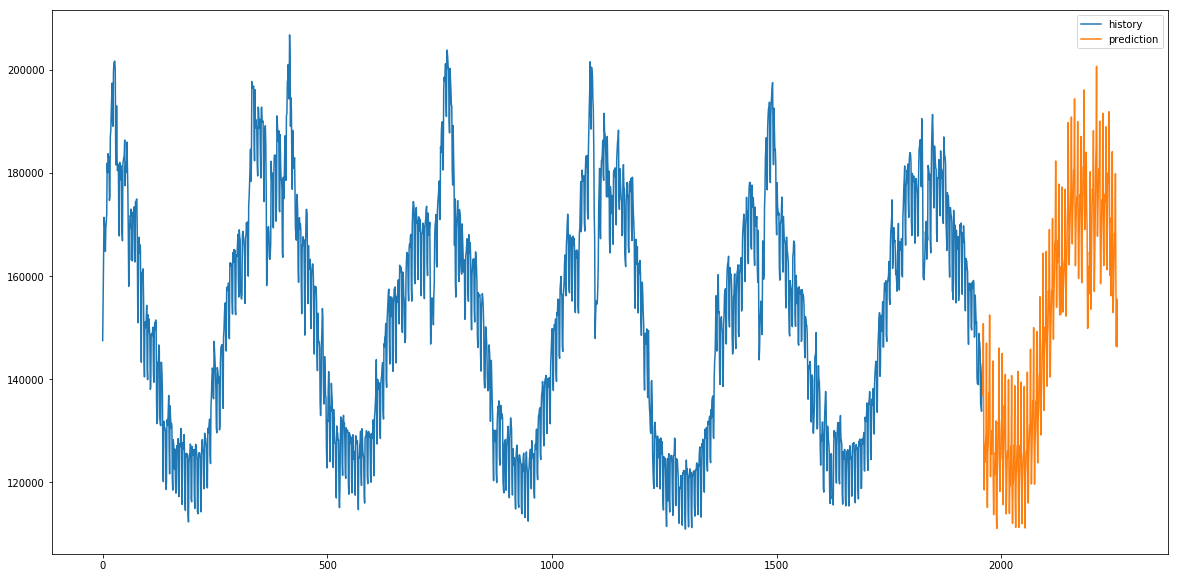

In [12]:
plt.plot(np.arange(len(data)), data, label="history")
plt.plot(np.arange(len(data), len(data)+300), predictions, label="prediction")
plt.legend();

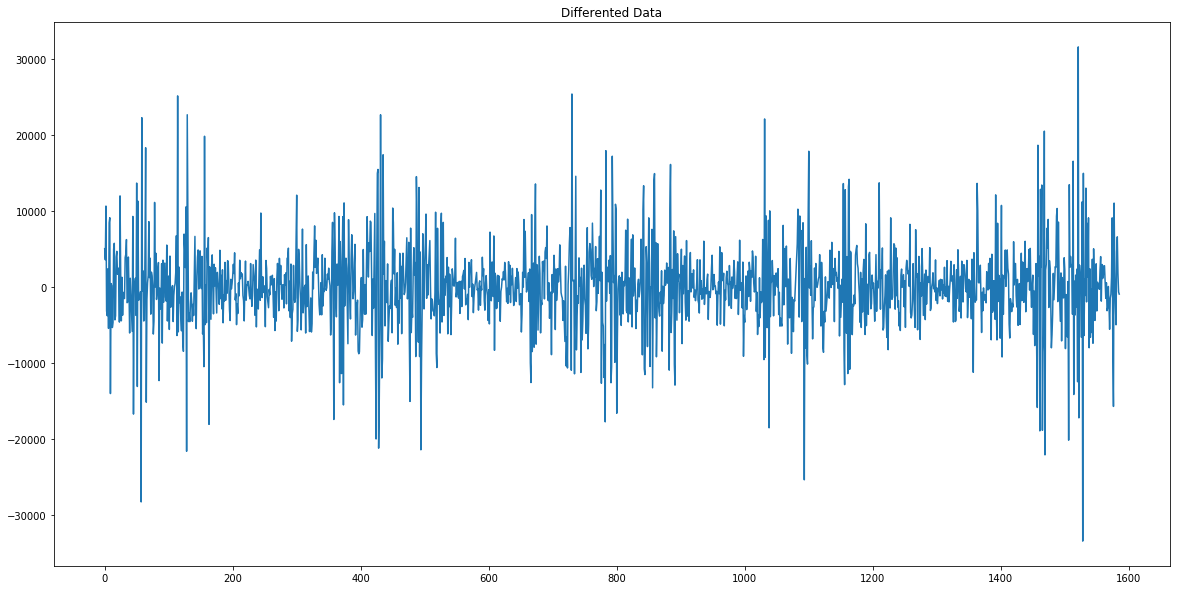

In [13]:
plt.plot(np.arange(len(ari.diff_matrix[-1])), ari.diff_matrix[-1])
plt.title("Differented Data")
plt.show()

## data monthly wage

In [14]:
data_wage = pd.read_csv("../data/monthly-wage.csv", sep=";")

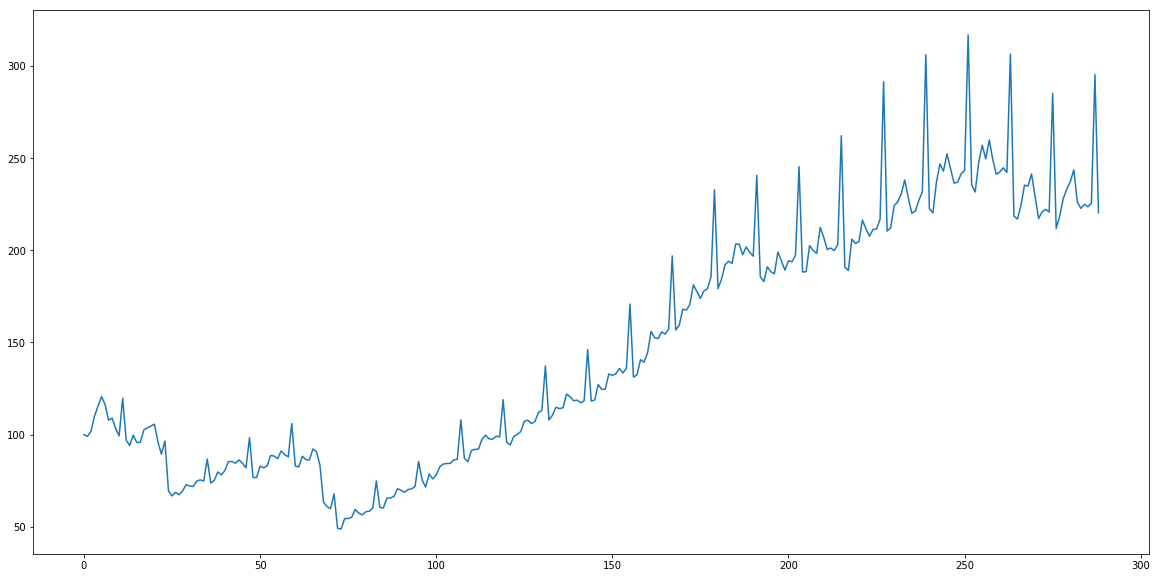

In [15]:
data1 = data_wage["Real wage"]
plt.plot(data1)

In [16]:
ari1 = ARI(window=100, s=[12], d=1, n=300)

In [17]:
ari1.train(list(data1))

In [18]:
prediction1 = ari1.predict()

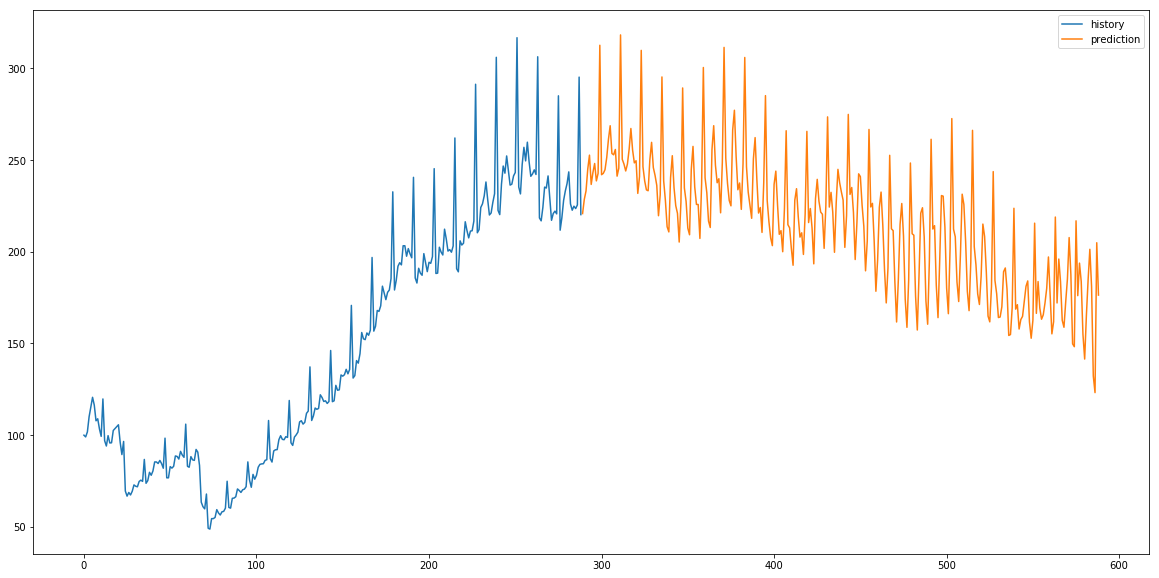

In [19]:
plt.plot(np.arange(len(data1)), data1, label="history")
plt.plot(np.arange(len(data1), len(data1)+300), prediction1, label="prediction")
plt.legend();

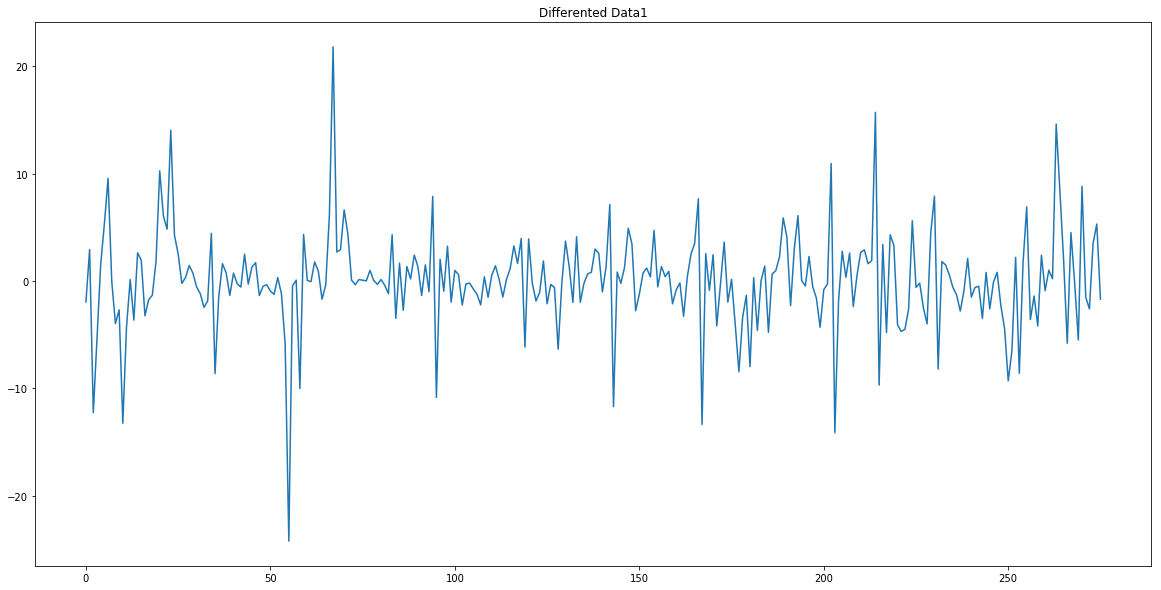

In [20]:
plt.plot(np.arange(len(ari1.diff_matrix[-1])), ari1.diff_matrix[-1])
plt.title("Differented Data1")
plt.show()